In [1]:
# -*- coding: utf-8 -*-
#
# Max-Planck-Gesellschaft zur Förderung der Wissenschaften e.V. (MPG) is
# holder of all proprietary rights on this computer program.
# Using this computer program means that you agree to the terms 
# in the LICENSE file included with this software distribution. 
# Any use not explicitly granted by the LICENSE is prohibited.
#
# Copyright©2019 Max-Planck-Gesellschaft zur Förderung
# der Wissenschaften e.V. (MPG). acting on behalf of its Max Planck Institute
# for Intelligent Systems. All rights reserved.
#
# For comments or questions, please email us at deca@tue.mpg.de
# For commercial licensing contact, please contact ps-license@tuebingen.mpg.de
#%%
import os, sys
import cv2
import numpy as np
from time import time
from scipy.io import savemat
import argparse
from tqdm import tqdm
import torch as th
import glob
import pandas as pd
from collections import defaultdict
import argparse
import blobfile as bf
import PIL

# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
sys.path.insert(0, '../')

from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg


from model_3d.FLAME import FLAME
from model_3d.FLAME.config import cfg as flame_cfg
from model_3d.FLAME.utils.renderer import SRenderY
import model_3d.FLAME.utils.util as util
flame = FLAME.FLAME(flame_cfg.model).cuda()
renderer = SRenderY(image_size=256, obj_filename=flame_cfg.model.topology_path, uv_size=flame_cfg.model.uv_size).cuda()

def params_to_model(shape, exp, pose, cam, light, uvdn=None):


    verts, landmarks2d, landmarks3d = flame(shape_params=shape, 
            expression_params=exp, 
            pose_params=pose)

    ## projection
    landmarks2d = util.batch_orth_proj(landmarks2d, cam)[:,:,:2]; landmarks2d[:,:,1:] = -landmarks2d[:,:,1:]#; landmarks2d = landmarks2d*self.image_size/2 + self.image_size/2
    landmarks3d = util.batch_orth_proj(landmarks3d, cam); landmarks3d[:,:,1:] = -landmarks3d[:,:,1:] #; landmarks3d = landmarks3d*self.image_size/2 + self.image_size/2
    trans_verts = util.batch_orth_proj(verts, cam); trans_verts[:,:,1:] = -trans_verts[:,:,1:]

    ## rendering
    shape_images = renderer.render_shape(verts, trans_verts)

    albedo = th.zeros([shape.shape[0], 3, flame_cfg.model.uv_size, flame_cfg.model.uv_size], device='cuda') 
    opdict = renderer(verts, trans_verts, albedo, light)

    # opdict = {'verts' : verts,}
    # os.makedirs('./rendered_obj', exist_ok=True)
    # save_obj(renderer=renderer, filename=(f'./rendered_obj/{i}.obj'), opdict=opdict)
    
    return {"shape_images":shape_images, "landmarks2d":landmarks2d, "landmarks3d":landmarks3d}, opdict

def load_params(path, params_key):
    '''
    Load & Return the params
    Input : 
    :params path: path of the pre-computed parameters
    :params params_key: list of parameters name e.g. ['pose', 'light']
    Return :
    :params params_s: the dict-like of {'0.jpg':}
    '''

    anno_path = glob.glob(f'{path}/*.txt')
    params = {}
    for k in params_key:
        for p in anno_path:
            # Params
            if k in p:
                print(f'Key=> {k} : Filename=>{p}')
                params[k] = read_params(path=p)

    params_s = swap_key(params)

    all_params = []
    for img_name in params_s:
        each_img = []
        for k in params_key:
            each_img.append(params_s[img_name][k])
        all_params.append(np.concatenate(each_img))
    all_params = np.stack(all_params, axis=0)
    return params_s, all_params

def read_params(path):
    params = pd.read_csv(path, header=None, sep=" ", index_col=False, lineterminator='\n')
    params.rename(columns={0:'img_name'}, inplace=True)
    params = params.set_index('img_name').T.to_dict('list')
    return params

def swap_key(params):
    params_s = defaultdict(dict)
    for params_name, v in params.items():
        for img_name, params_value in v.items():
            params_s[img_name][params_name] = np.array(params_value).astype(np.float64)

    return params_s

def to_tensor(cond, key, device):
    for k in key:
        cond[k] = th.tensor(cond[k]).to(device).float()
    return cond

def _list_image_files_recursively(data_dir):
    results = []
    for entry in sorted(bf.listdir(data_dir)):
        full_path = bf.join(data_dir, entry)
        ext = entry.split(".")[-1]
        if "." in entry and ext.lower() in ["jpg", "jpeg", "png", "gif"]:
            results.append(full_path)
        elif bf.isdir(full_path):
            results.extend(_list_image_files_recursively(full_path))
    return results

def load_image(path):
    '''
    Load image and stack all of thems into BxCxHxW
    '''
    with bf.BlobFile(path, "rb") as f:
        pil_image = PIL.Image.open(f)
        pil_image.load()
    pil_image = pil_image.convert("RGB")

    raw_img = np.array(pil_image)

    raw_img = np.transpose(raw_img, (2, 0, 1))
    return th.tensor(raw_img)

def normalize_image(img, convention='CHW'):
    '''
    :params img: the input image
    '''
    if convention == 'CHW':
        agg_axes = (1, 2)
    elif convention == 'HWC':
        agg_axes = (0, 1)
    else: NotImplementedError
    
    img = (img - np.min(img, axis=agg_axes, keepdims=True)) / (np.max(img, axis=agg_axes, keepdims=True) - np.min(img, axis=agg_axes, keepdims=True))
    return img


ImportError: /home/mint/miniconda3/envs/deca/lib/python3.8/site-packages/pytorch3d/_C.cpython-38-x86_64-linux-gnu.so: undefined symbol: _ZN3c104cuda12device_countEv

In [4]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--path', required=True)
# args = parser.parse_args()
params_path = "/data/mint/ffhq_256_with_anno/params/valid"
img_path = "/data/mint/ffhq_256_with_anno/ffhq_256/valid"
device = 'cuda' if th.cuda.is_available() and th._C._cuda_getDeviceCount() > 0 else 'cpu'

params_dict, params_arr = load_params(path=params_path, params_key=['shape', 'pose', 'exp', 'cam', 'light'])

Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-cam-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-light-anno.txt


In [8]:
if __name__ == '__main__':
  
    img_name = '60019.jpg'

    all_img_path = _list_image_files_recursively(img_path)
    img_path_dict = {}
    for path in all_img_path:
        tmp = path.split('/')[-1]
        img_path_dict[tmp] = {'path':path}
    img = load_image(path=img_path_dict[img_name]['path'])
    
    params_dict[img_name] = to_tensor(params_dict[img_name], key=['shape', 'pose', 'exp', 'cam', 'light'], device=device)

    flame_model_3d, opdict = params_to_model(
        shape=params_dict[img_name]['shape'][None, ...], 
        exp=params_dict[img_name]['exp'][None, ...], 
        pose=params_dict[img_name]['pose'][None, ...], 
        cam=params_dict[img_name]['cam'][None, ...],
        light=params_dict[img_name]['light'][None, ...].reshape(-1, 9, 3),

    )

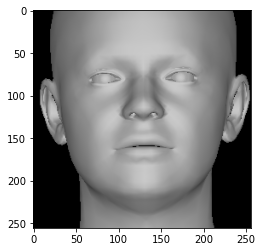

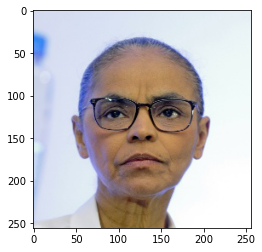

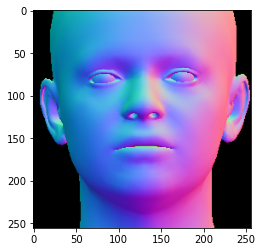

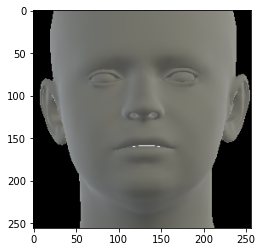

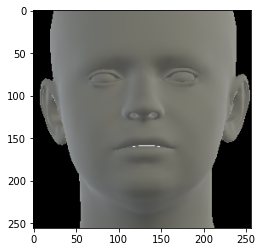

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


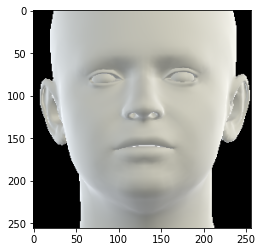

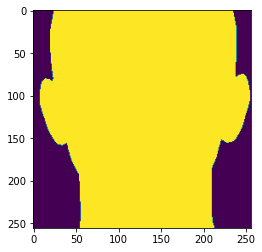

In [9]:
#%%
from ssl import OP_ALL
import matplotlib.pyplot as plt
plt.imshow(np.transpose(flame_model_3d['shape_images'][0].cpu().numpy(), axes=(1, 2, 0)))
plt.show()

plt.imshow(np.transpose(img.cpu().numpy(), axes=(1, 2, 0)))
plt.show()

alpha_images = np.transpose(opdict['alpha_images'][0].cpu().numpy(), axes=(1, 2, 0))
normal_images = np.transpose(opdict['normal_images'][0].cpu().numpy(), axes=(1, 2, 0))
plt.imshow((((normal_images + 1) * 127.5) * alpha_images).astype(np.uint8))
plt.show()

shading = renderer.add_SHlight(normal_images=opdict['normal_images'], sh_coeff=params_dict[img_name]['light'][None, ...].reshape(-1, 9, 3))
shading = np.transpose(shading[0].cpu().numpy(), axes=(1, 2, 0))
plt.imshow(normalize_image(shading * alpha_images, convention='HWC'))
plt.show()

shading_images = np.transpose(opdict['shading_images'][0].cpu().numpy(), axes=(1, 2, 0))
plt.imshow(normalize_image(shading_images * alpha_images, convention='HWC'))
plt.show()
plt.imshow(shading_images * alpha_images)
plt.show()

plt.imshow(alpha_images)
plt.show()


# Automated script

In [6]:

set_ = 'train'
save_path = "/data/mint/ffhq_256_with_anno/"
alpha_images_path = f"{save_path}/alpha_images/{set_}"
normal_images_path = f"{save_path}/normal_images/{set_}"
shading_images_path = f"{save_path}/shading_images/{set_}"
shading_images_norm_path = f"{save_path}/shading_images_norm/{set_}"

os.makedirs(f"{save_path}/normal_images/{set_}", exist_ok=True)
os.makedirs(alpha_images_path, exist_ok=True)
os.makedirs(normal_images_path, exist_ok=True)
os.makedirs(shading_images_path, exist_ok=True)
os.makedirs(shading_images_norm_path, exist_ok=True)

params_path = f"/data/mint/ffhq_256_with_anno/params/{set_}"
img_path = f"/data/mint/ffhq_256_with_anno/ffhq_256/{set_}"
device = 'cuda' if th.cuda.is_available() and th._C._cuda_getDeviceCount() > 0 else 'cpu'

params_dict, params_arr = load_params(path=params_path, params_key=['shape', 'pose', 'exp', 'cam', 'light'])

all_img_path = _list_image_files_recursively(img_path)
img_path_dict = {}
for path in all_img_path:
    tmp = path.split('/')[-1]
    img_path_dict[tmp] = {'path':path}

import tqdm
from torchvision.utils import save_image
for img_name in tqdm.tqdm(img_path_dict.keys()):
    img = load_image(path=img_path_dict[img_name]['path'])

    params_dict[img_name] = to_tensor(params_dict[img_name], key=['shape', 'pose', 'exp', 'cam', 'light'], device=device)

    flame_model_3d, opdict = params_to_model(
        shape=params_dict[img_name]['shape'][None, ...], 
        exp=params_dict[img_name]['exp'][None, ...], 
        pose=params_dict[img_name]['pose'][None, ...], 
        cam=params_dict[img_name]['cam'][None, ...],
        light=params_dict[img_name]['light'][None, ...].reshape(-1, 9, 3),

    )

    # Alpha
    alpha_images = opdict['alpha_images'] 
    # Normals 
    normal_images = ((opdict['normal_images'] + 1) * 127.5)/255.0
    normal_images = normal_images * alpha_images
    # Shading 
    shading_images = opdict['shading_images'] * alpha_images
    shading_images_norm = normalize_image(shading_images[0].cpu().numpy(), convention='CHW')[None, ...]
    shading_images_norm = th.tensor(shading_images_norm)
    save_image(alpha_images, f'{alpha_images_path}/{img_name}')
    save_image(normal_images, f'{normal_images_path}/{img_name}')
    save_image(shading_images, f'{shading_images_path}/{img_name}')
    save_image(shading_images_norm, f'{shading_images_norm_path}/{img_name}')



Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-cam-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-light-anno.txt


100%|██████████| 60000/60000 [48:44<00:00, 20.52it/s]  
